# 09. 단순회귀

In [2]:
library(bayesrules)
library(tidyverse)
library(rstan)
library(rstanarm)
library(bayesplot)
library(tidybayes)
library(janitor)
library(broom.mixed)

<br>

## 09.01. 회귀모형 구축 

<br>

### 베이지안 정규회귀 절차
> **$Y$가 반응변수이고, $X$가 설명변수일 때,**
> 

>**1. 반응변수의 특성을 고려하여 적절한 분포설정 (ex: 정규분포, 포아송, 이항분포 등)**
>
>**2. $Y$의 평균을, 설명변수로 재구성 (ex: $\mu = \beta_0 + \beta_1 X$)**
>
>**3. 사전분포를 가져야 하는 매개변수를 정의 (ex : $\beta_0, \beta_1, \sigma$)**
>
>**4. 매개변수별 적절한 사전분포 설정**
>
>    **매개변수별 사전분포는 서로 독립적이라고 가정**


<br>

<hr>

#### 예시
$$\begin{equation}
\begin{split}
Y_i | \beta_0, \beta_1, \sigma & \stackrel{ind}{\sim} N\left(\mu_i, \sigma^2\right) \;\; \text{ with } \;\; \mu_i = \beta_0 + \beta_1X_i  .\\
\end{split}
\end{equation}$$
> 1. 데이터의 구조
>
>  $N$개의 관측값 쌍 $\left\lbrace (Y_1,X_1), (Y_2,X_2),...,(Y_n,X_n) \right\rbrace$에서, $i$번째 관측값 $Y_I$은 $j$번째 관측값 $Y_j$와 독립
>

> 2. 변수간의 관계
>
>  $Y$가 $X$가 선형관계라면,  $\mu_i = \beta_0 + \beta_1 X_i$
>

> 3. 변동성
>
>  모든 $X$에 대해서 $Y$는, $\mu$와 표준편차 $\sigma$를 가지는 정규분포를 따름 
>
>  $Y_i | \mu,\sigma \sim N(\mu, \sigma^2)$


<br>

#### 사전분포 설정
- 회귀계수 $\beta_0$, $\beta_1$, $Y$의 표준편차 $\sigma$의 사전분포
- **매개변수별 사전분포는 서로 독립적**

$$\begin{equation}
\begin{split} 
\beta_0  &  \sim N\left(m_0, s_0^2 \right)  \\
\beta_1  & \sim N\left(m_1, s_1^2 \right) \\
\end{split}
\end{equation}$$

$$\begin{equation}
\begin{split} 
\sigma & \sim \text{Exp}(l)  .\\
\end{split}
\end{equation}$$

$$E(\sigma) = \frac{1}{l} \;\; \text{ and } \;\; SD(\sigma) = \frac{1}{l}.$$

<br>

#### 따라서
$$\begin{equation}
\begin{array}{lcrl} 
\text{data:} & \hspace{.05in} &  Y_i | \beta_0, \beta_1, \sigma & \stackrel{ind}{\sim} N\left(\mu_i, \sigma^2\right) \;\; \text{ with } \;\; \mu_i = \beta_0 + \beta_1X_i \\
\text{priors:} & & \beta_0  &  \sim N\left(m_0, s_0^2 \right)  \\
                     & & \beta_1  & \sim N\left(m_1, s_1^2 \right) \\
                     & & \sigma & \sim \text{Exp}(l)  .\\
\end{array}
\end{equation}$$

<br>

## 09.02. 사전분포 조정

### 주어진 관측값의 특성과 사전정보를 통하여, 사전분포를 조정

<br>

#### 예)
- $X$가 평균일 때 $Y$는 일반적으로 5000의 값을 가지지만, 이 값은 적게는 3000, 크게는 7000의 값일 수도 있다. 
- $X$가 한 단위 증가할 때마다, $Y$는 일반적으로 200씩 증가하며, 이 증가폭은 적게는 20, 크게는 180일 수도 있다
- $Y$의 표준편차는 1250의 평균을 가짐 

    $E(\sigma) = 1/l = 1250$
    
<br>

#### 따라서

$$\begin{equation}
\begin{split}
Y_i | \beta_0, \beta_1, \sigma & \stackrel{ind}{\sim} N\left(\mu_i, \sigma^2\right) \;\; \text{ with } \;\; \mu_i = \beta_0 + \beta_1X_i \\
\beta_{0c}  & \sim N\left(5000, 1000^2 \right)  \\
\beta_1  & \sim N\left(100, 40^2 \right) \\
\sigma   & \sim \text{Exp}(0.0008)  .\\
\end{split}
\end{equation}$$

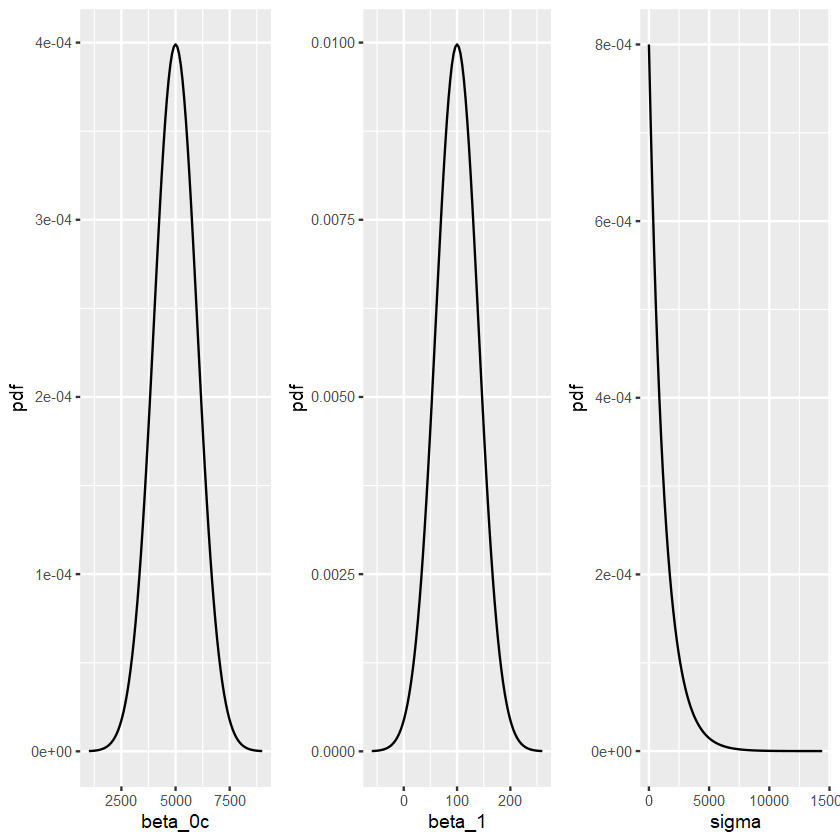

In [5]:
plot_normal(mean = 5000, sd = 1000) + 
  labs(x = "beta_0c", y = "pdf") -> p1
plot_normal(mean = 100, sd = 40) + 
  labs(x = "beta_1", y = "pdf") -> p2
plot_gamma(shape = 1, rate = 0.0008) + 
  labs(x = "sigma", y = "pdf") -> p3

gridExtra::grid.arrange(p1, p2, p3, nrow = 1)

<br>

## 08.03. 시뮬레이션

`geom_smooth()` using formula = 'y ~ x'


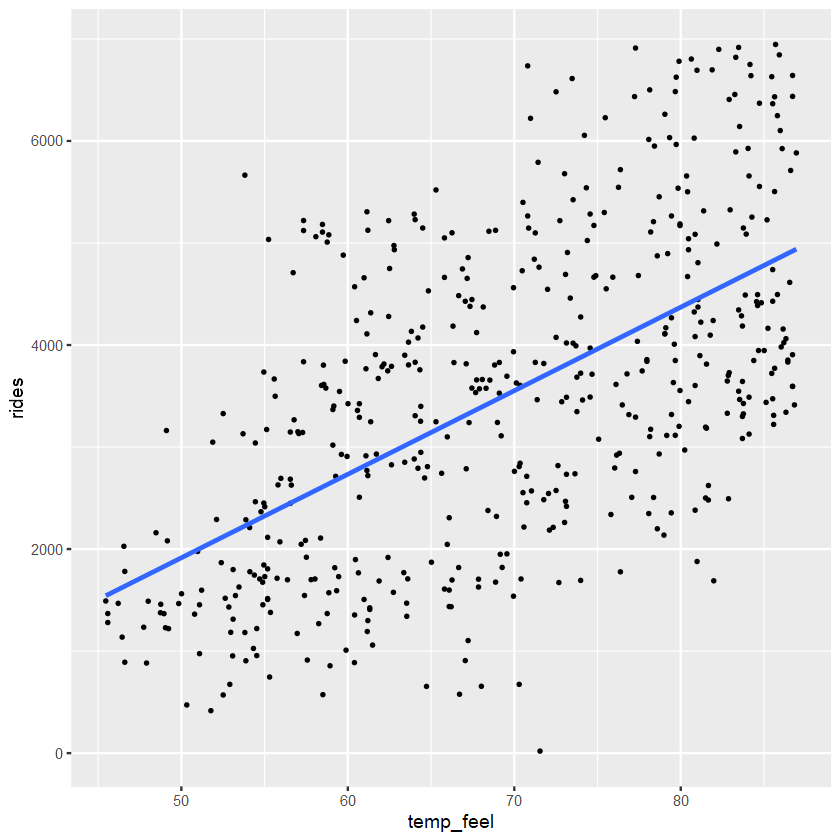

In [6]:
data(bikes)
ggplot(bikes, aes(x = temp_feel, y = rides)) + 
  geom_point(size = 0.5) + 
  geom_smooth(method = "lm", se = FALSE)

<br>

#### 각 매개변수별 사후분포는 서로 독립적이라고 가정하기에, 사전결합분포는 사전분포의 곱으로 구성

$$f(\beta_0, \beta_1, \sigma) = f(\beta_0) f(\beta_1) f(\sigma)  .$$

<br>

#### 관측값 $\vec{y} = (y_1,y_2,...,y_{n})$에 대하여, 가능도는

$$L(\beta_0, \beta_1, \sigma | \vec{y}) = f(\vec{y}|\beta_0, \beta_1, \sigma) = \prod_{i=1}^{n}f(y_i|\beta_0, \beta_1, \sigma)  .$$

<br>

#### 따라서, 매개변수 $(\beta_0, \beta_1, \sigma)$에 대한 사후결합분포는

$$f(\beta_0,\beta_1,\sigma \; | \; \vec{y}) 
\propto \text{prior} \cdot \text{likelihood}
 = f(\beta_0) f(\beta_1) f(\sigma) \cdot \left[\prod_{i=1}^{n}f(y_i | \beta_0, \beta_1, \sigma) \right] .$$

$$\begin{split}
f(\beta_0,\beta_1,\sigma \; | \; \vec{y}) 
 & = \frac{\text{prior} \cdot \text{likelihood}}{ \int \text{prior} \cdot \text{likelihood}} \\
 & = \frac{f(\beta_0) f(\beta_1) f(\sigma) \cdot \left[\prod_{i=1}^{n}f(y_i|\beta_0, \beta_1, \sigma) \right]}
 {\int\int\int f(\beta_0) f(\beta_1) f(\sigma) \cdot \left[\prod_{i=1}^{n}f(y_i|\beta_0, \beta_1, \sigma) \right] d\beta_0 d\beta_1 d\sigma} \\
 \end{split}$$

<br>

### `rstanarm`패키지

<br>

#### `rstanarm::stan_glm(formula, data, family, ...)` : 일반화 선형 회귀 모델

In [ ]:
bike_model <- stan_glm(formula = rides ~ temp_feel, 
                       data = bikes,
                       family = gaussian, # 관측값의 정규분포 가정
                       prior_intercept = normal(5000, 1000), # 절편에 대한 사전분포
                       prior = normal(100, 40), # 회귀계수에 대한 사전분포
                       prior_aux = exponential(0.0008), # 관측값 분산에 대한 사전분포
                       chains = 4, iter = 5000*2, seed = 84735)

- 시뮬레이션을 통하여, 각 매개변수에 대한 마르코프 체인 생성 
    
    $\left\lbrace \beta_0^{(1)}, \beta_0^{(2)}, \ldots, \beta_0^{(5000)} \right\rbrace$, $\left\lbrace \beta_1^{(1)}, \beta_1^{(2)}, \ldots, \beta_1^{(5000)} \right\rbrace$, $\left\lbrace \sigma_0^{(1)}, \sigma_0^{(2)}, \ldots, \sigma_0^{(5000)} \right\rbrace$

In [10]:
neff_ratio(bike_model)

(Intercept)   temp_feel       sigma 
    1.01655     1.00960     0.98635

In [11]:
rhat(bike_model)

(Intercept)   temp_feel       sigma 
  0.9999477   0.9999072   0.9999549

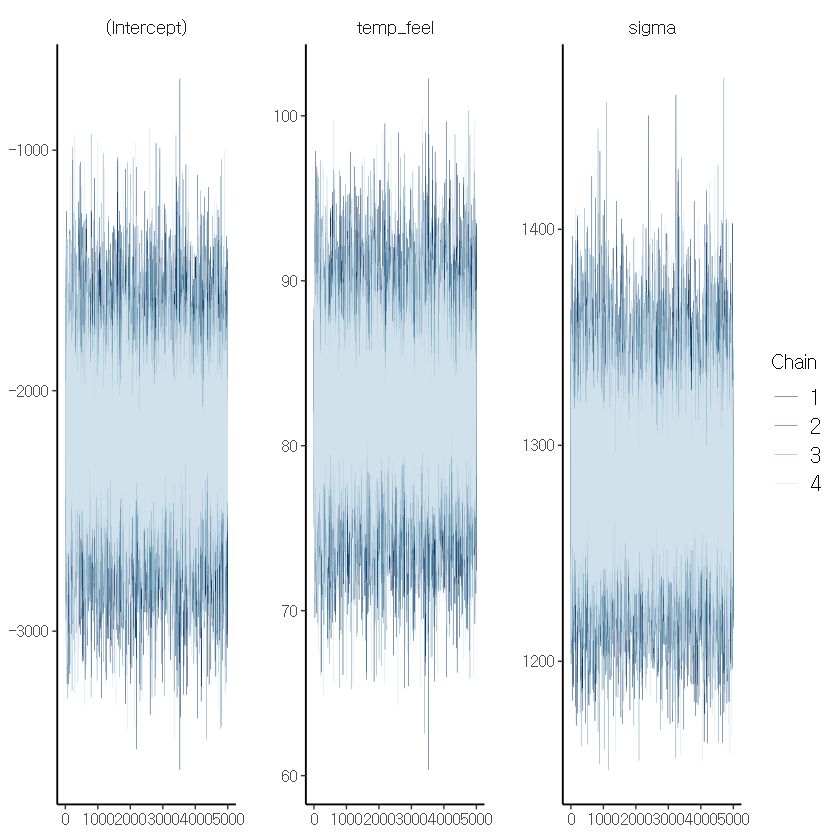

In [12]:
mcmc_trace(bike_model, size = 0.1)

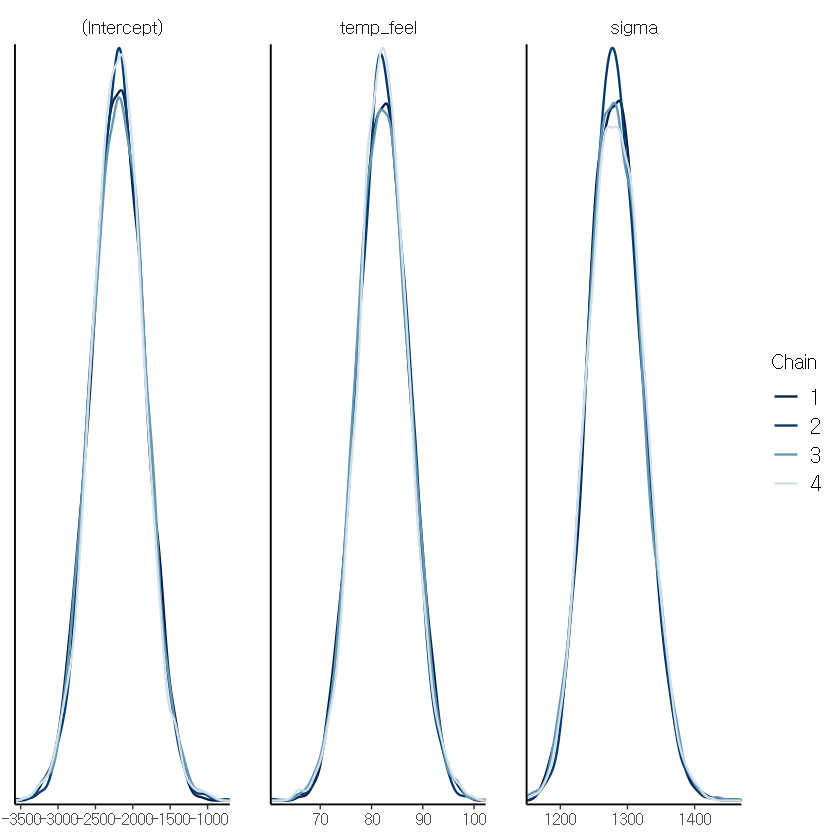

In [13]:
mcmc_dens_overlay(bike_model)

<br>

### `rstan`패키지

In [14]:
stan_bike_model <- "
  data {
    int<lower = 0> n;
    vector[n] Y;
    vector[n] X;
  }
  parameters {
    real beta0;
    real beta1;
    real<lower = 0> sigma;
  }
  model {
    Y ~ normal(beta0 + beta1 * X, sigma);
    beta0 ~ normal(-2000, 1000);
    beta1 ~ normal(100, 40);
    sigma ~ exponential(0.0008);
  }
"

In [ ]:
stan_bike_sim <- stan(model_code = stan_bike_model, 
                      data = list(n = nrow(bikes), Y = bikes$rides, X = bikes$temp_feel), 
                      chains = 4, iter = 5000*2, seed = 84735)

<br>

## 09.04. 사후분포 해석

In [16]:
tidy(bike_model, effects = c("fixed", "aux"),
     conf.int = TRUE, conf.level = 0.80)

term,estimate,std.error,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-2195.07142,358.545337,-2657.01942,-1741.23595
temp_feel,82.19292,5.046023,75.72758,88.78104
sigma,1281.93347,40.637460,1231.55905,1335.88324
mean_PPD,3486.67387,80.827416,3382.70508,3589.55986


#### 각 매개변수별 사후분포의 중앙값을 통하여, 회귀계수 추정량은
$$\begin{equation}
-2195.07 + 82.19 X 
\end{equation}$$

<br>

#### 각 매개변수별 마르코프 체인 값

In [19]:
bike_model_df <- as.data.frame(bike_model)
bike_model_df %>% dim

[1] 20000     3

In [18]:
head(bike_model_df, 3)

,(Intercept),temp_feel,sigma
,<dbl>,<dbl>,<dbl>
1,-2593.578,87.59029,1362.773
2,-2207.766,82.06586,1236.125
3,-2515.712,86.25428,1329.203


<br>

#### `add_fitted_draws(model, n)` : 마르코프 체인 값에서 `n`개의 값 쌍을 선택하여, 실제 데이터에 적합

$$\beta_0^{(i)} + \beta_1^{(i)}X$$

Warning message:
"`fitted_draws` and `add_fitted_draws` are deprecated as their names were confusing.
- Use [add_]epred_draws() to get the expectation of the posterior predictive.
- Use [add_]linpred_draws() to get the distribution of the linear predictor.
- For example, you used [add_]fitted_draws(..., scale = "response"), which
  means you most likely want [add_]epred_draws(...).
NOTE: When updating to the new functions, note that the `model` parameter is now
  named `object` and the `n` parameter is now named `ndraws`."


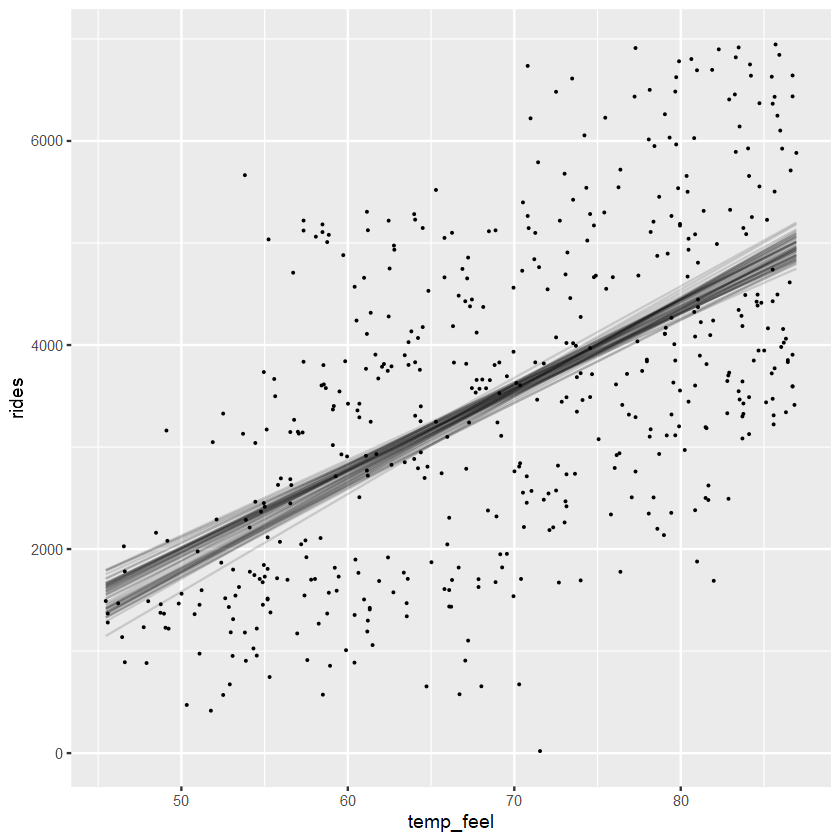

In [23]:
bikes %>%
  add_fitted_draws(bike_model, n = 50) %>%
  ggplot(aes(x = temp_feel, y = rides)) +
    geom_line(aes(y = .value, group = .draw), alpha = 0.15) + 
    geom_point(data = bikes, size = 0.05)

<br>

#### $\beta_1 > 0$, $X$가 $Y$와 양의 선형관계라는 근거
1. 시각적 증명

Warning message:
"
In add_predicted_draws(): The `n` argument is a deprecated alias for `ndraws`.
Use the `ndraws` argument instead.
See help("tidybayes-deprecated").
"


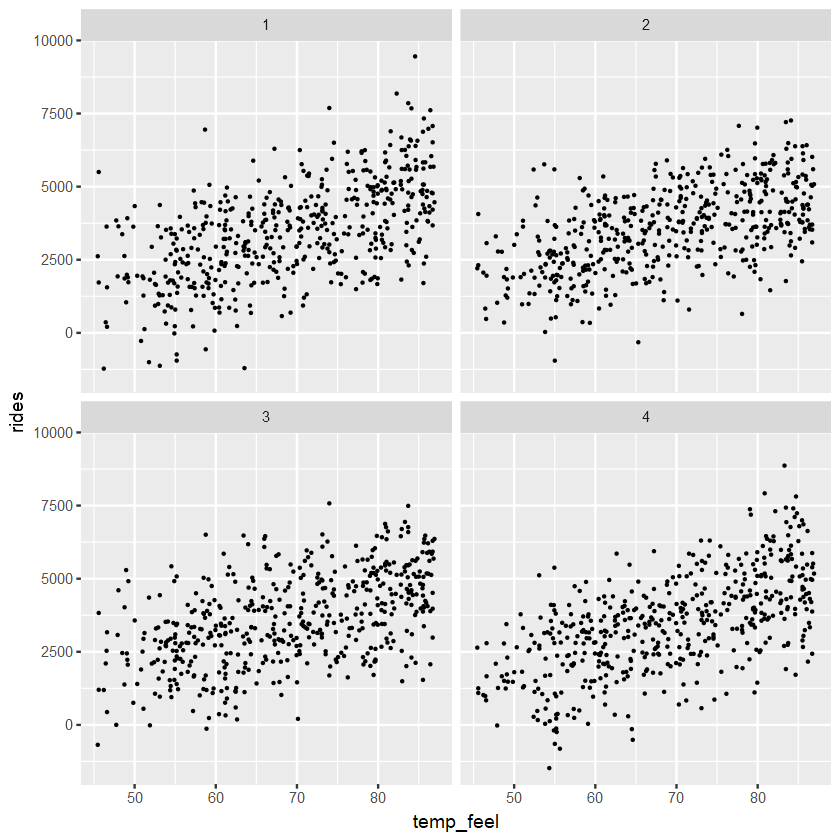

In [24]:
bikes %>%
  add_predicted_draws(bike_model, n = 4) %>%
  ggplot(aes(x = temp_feel, y = rides)) +
    geom_point(aes(y = .prediction, group = .draw), size = 0.2) + 
    facet_wrap(~ .draw)

2. $\beta_1$의 95% 신용구간
3. $\beta_1$의 모든 마르코프 체인 값들은 1보다 높음

    $P(\beta_1 > 0 \; | \; \vec{y}) \approx 1$

In [34]:
bike_model_df %>% 
  mutate(exceeds_0 = temp_feel > 0) %>% 
  tabyl(exceeds_0)

exceeds_0,n,percent
<lgl>,<int>,<dbl>
TRUE,20000,1


<br>

## 09.05. 사후예측
#### 신규 관측값 $Y_{new}$의 변동성에 대한 정의와, 매개변수별 사후분포에 의한 매개변수의 범위와 변동성에 대한 정의에 따라

$$f\left(y_{\text{new}} | \vec{y}\right) = \int\int\int f\left(y_{new} | \beta_0,\beta_1,\sigma\right) f(\beta_0,\beta_1,\sigma|\vec{y}) d\beta_0 d\beta_1 d\sigma .$$

#### (만약 $X_{new}=75$일 때, 매개변수에 따른 $X_{new}$와 $X_{new}$에 의한 $Y_{new}$의 변동성을 고려해야 하며)
#### (각 매개변수는 관측값 기존 관측값 $Y$에 따른 변동성을 고려 해야함)


<br>

#### 따라서 사후예측분포를 근사시키기 위하여, $\left(\beta_0^{(i)},\beta_1^{(i)},\sigma^{(i)}\right)$의 마르코프 체인 값에 대하여

$$Y_{\text{new}}^{(i)} | \beta_0, \beta_1, \sigma  \; \sim \; N\left(\mu^{(i)}, \left(\sigma^{(i)}\right)^2\right) \;\; \text{ with } \;\; \mu^{(i)} = \beta_0^{(i)} + \beta_1^{(i)} \cdot 75.$$

#### 신규관측값 $X_{new}=75$를 대입하여, 각 마르코프 체인 값 별 $Y_{new}$를 얻음 $\rightarrow$ $\left\lbrace Y_{\text{new}}^{(1)}, Y_{\text{new}}^{(2)}, \ldots, Y_{\text{new}}^{(20000)} \right\rbrace$

$$\left[
\begin{array}{lll} 
\beta_0^{(1)} & \beta_1^{(1)} & \sigma^{(1)} \\
\beta_0^{(2)} & \beta_1^{(2)} & \sigma^{(2)} \\
\vdots & \vdots & \vdots \\
\beta_0^{(20000)} & \beta_1^{(20000)} & \sigma^{(20000)} \\
\end{array}
\right]
\;\; \longrightarrow \;\;
\left[
\begin{array}{l} 
Y_{\text{new}}^{(1)} \\
Y_{\text{new}}^{(2)} \\
\vdots \\
Y_{\text{new}}^{(20000)} \\
\end{array}
\right]$$

<br>

### 구현


#### $1$번째 체인값에 의하여

$$\left(\beta_0^{(1)}, \beta_1^{(1)}, \sigma^{(1)}\right) = (-2594, 87.59, 1363)$$
$$\downarrow$$
$$\mu = \beta_0^{(1)} + \beta_1^{(1)} X = -2594 + 87.59X  .$$

In [35]:
first_set <- head(bike_model_df, 1)
first_set

,(Intercept),temp_feel,sigma
,<dbl>,<dbl>,<dbl>
1,-2593.578,87.59029,1362.773


$$Y_{\text{new}}^{(1)} | \beta_0, \beta_1, \sigma  \; \sim \; N\left(3976, 1363^2\right)  .$$

In [37]:
mu <- first_set$`(Intercept)` + first_set$temp_feel * 75
mu

[1] 3975.694

#### $1$번째 체인값에 의한 $X_{new}=75$에 대한 예측값은 4885

In [61]:
set.seed(84735)
y_new <- rnorm(1, mean = mu, sd = first_set$sigma)
y_new

[1] 4884.981

<br>

#### 나머지 체인값에 대해서도 동일한 방식 적용

In [62]:
set.seed(84735)
predict_75 <- bike_model_df %>% 
  mutate(mu = `(Intercept)` + temp_feel*75,
         y_new = rnorm(20000, mean = mu, sd = sigma))

predict_75 %>% head

,(Intercept),temp_feel,sigma,mu,y_new
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-2593.578,87.59029,1362.773,3975.694,4884.981
2,-2207.766,82.06586,1236.125,3947.173,3794.091
3,-2515.712,86.25428,1329.203,3953.359,4991.291
4,-2375.081,84.91562,1338.868,3993.590,4310.792
5,-2367.439,84.10546,1214.250,3940.471,4907.634
6,-2314.622,83.75800,1198.817,3967.228,5865.252


<br>

#### 20000개의 각 체인값 별 $X_{new}=75$에 대한 예측값들을 통하여, $Y_{new}$에 대한 사후예측분포를 근사

In [63]:
predict_75 %>% 
  summarize(lower_mu = quantile(mu, 0.025),
            upper_mu = quantile(mu, 0.975),
            lower_new = quantile(y_new, 0.025),
            upper_new = quantile(y_new, 0.975))

lower_mu,upper_mu,lower_new,upper_new
<dbl>,<dbl>,<dbl>,<dbl>
3842.508,4093.436,1492.104,6488.281


<br>

- $Y$의 평균인 $\mu$의 사후분포와 비교하였을 때, 사후예측분포는 더 넓은 신용구간을 가짐


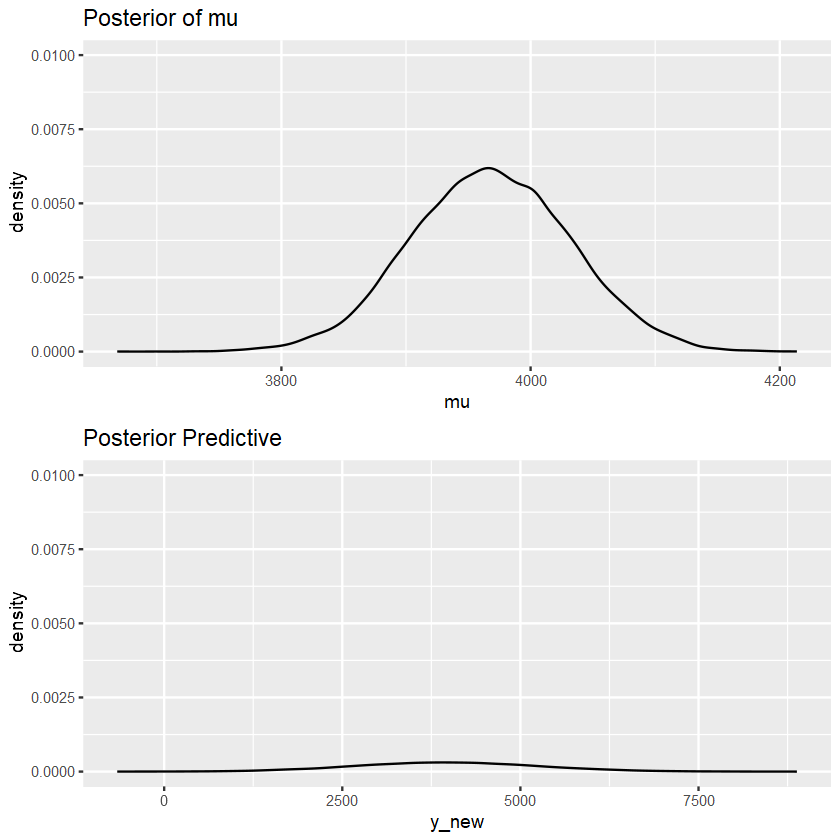

In [71]:
ggplot(predict_75, aes(x = mu)) + ylim(0, 0.01) + 
  geom_density() + ggtitle("Posterior of mu") -> p1

ggplot(predict_75, aes(x = y_new)) + ylim(0, 0.01) +
  geom_density() + ggtitle("Posterior Predictive") -> p2

gridExtra::grid.arrange(p1, p2)

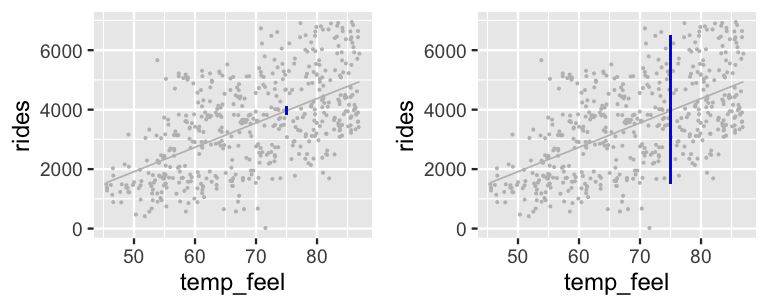

<br>

### 구현 (`rstanarm` 패키지)

#### `rstanarm::posterior_prediction(model, newdata)` : 신규 관측값 `newdata`에 대한 사후예측분포 생성

In [72]:
set.seed(84735)
shortcut_prediction <- posterior_predict(bike_model, newdata = data.frame(temp_feel = 75))

In [73]:
posterior_interval(shortcut_prediction, prob = 0.95)

,2.5%,97.5%
1,1492.104,6488.281


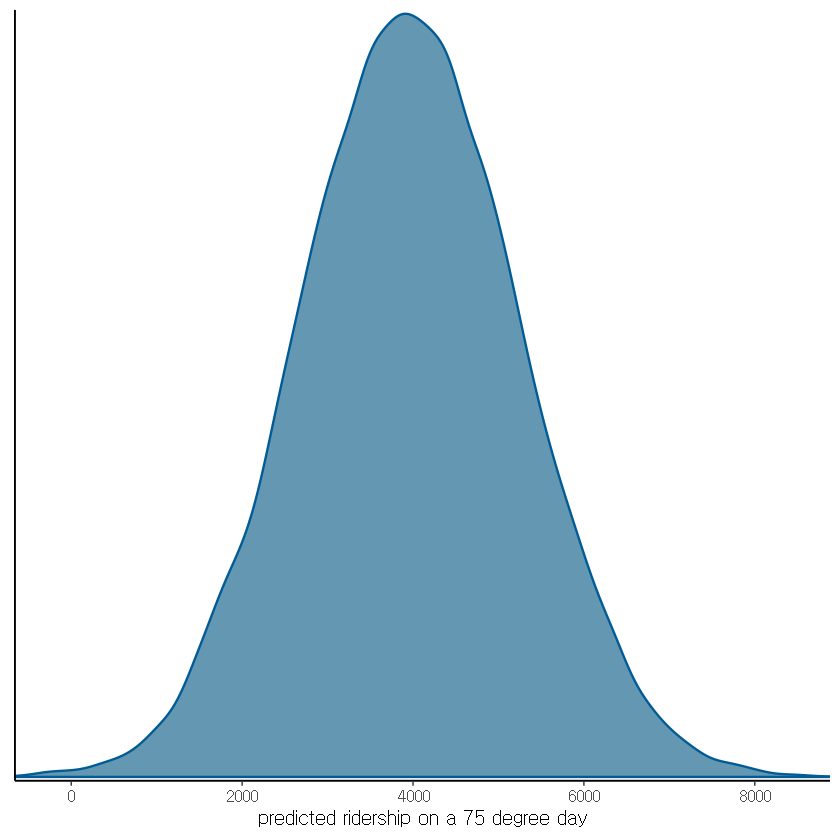

In [74]:
mcmc_dens(shortcut_prediction) + 
  xlab("predicted ridership on a 75 degree day")

<br>

## 09.06. 순서성을 고려한 모델

In [75]:
bikes %>% 
  select(date, temp_feel, rides) %>% 
  head(3)

,date,temp_feel,rides
,<date>,<dbl>,<int>
1,2011-01-01,64.72625,654
2,2011-01-03,49.04645,1229
3,2011-01-04,51.09098,1454


<br>

#### 데이터가 점진적으로 증가한다는 가정
- phase 1: 1일부터 30일까지
- phase 2: 1일부터 60일까지
- phase 3: 1일부터 마지막까지

In [76]:
phase_1 <- bikes[1:30, ]
phase_2 <- bikes[1:60, ]
phase_3 <- bikes

<br>

#### 관측 데이터가 점진적으로 증가하면서,  $X$와 $Y$간의 양의 선형관계가 뚜렷해짐

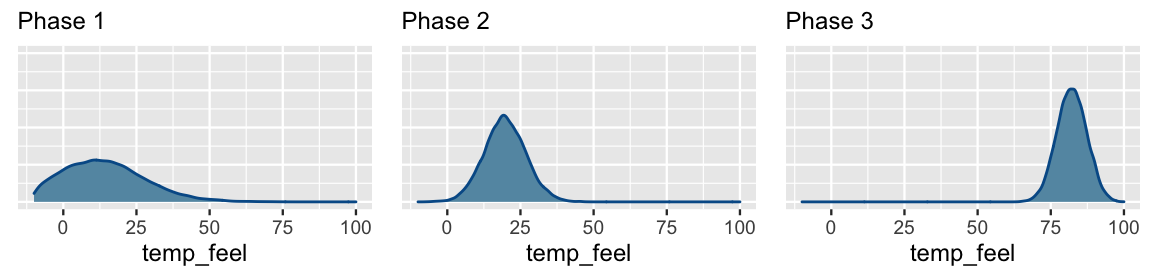

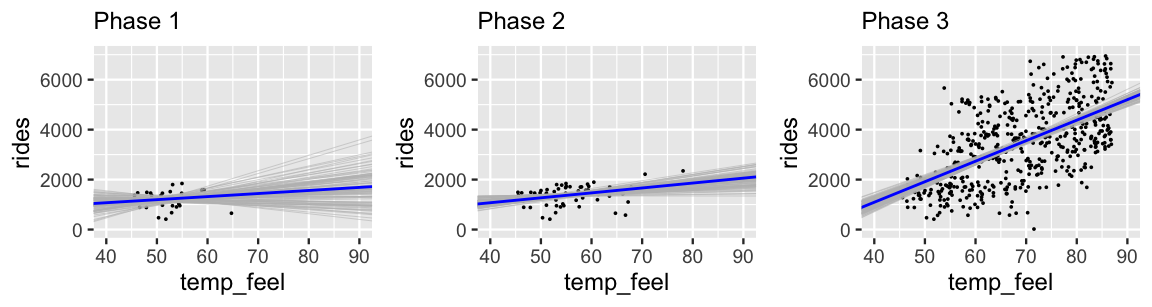

<br>

## 09.07. `rstanarm` 패키지의 기본 사전분포 사용

#### 각 매개변수별 사전분포 구축을 위한 사전정보가 불확실한 경우, 각 사전분포에 `autoscale=TRUE`를 입력하여, 자동으로 조정

In [ ]:
bike_model_default <- stan_glm(
  rides ~ temp_feel, data = bikes, 
  family = gaussian,
  prior_intercept = normal(5000, 2.5, autoscale = TRUE),
  prior = normal(0, 2.5, autoscale = TRUE), 
  prior_aux = exponential(1, autoscale = TRUE),
  chains = 4, iter = 5000*2, seed = 84735)

<br>

#### `prior_summary()` : 사전분포 정보확인

In [101]:
prior_summary(bike_model_default)

Priors for model 'bike_model_default' 
------
Intercept (after predictors centered)
  Specified prior:
    ~ normal(location = 5000, scale = 2.5)
  Adjusted prior:
    ~ normal(location = 5000, scale = 3937)

Coefficients
  Specified prior:
    ~ normal(location = 0, scale = 2.5)
  Adjusted prior:
    ~ normal(location = 0, scale = 351)

Auxiliary (sigma)
  Specified prior:
    ~ exponential(rate = 1)
  Adjusted prior:
    ~ exponential(rate = 0.00064)
------
See help('prior_summary.stanreg') for more details

<br>

#### `autoscale=TRUE`로 조정된 사전분포를 통하여, 다시 시뮬레이션

In [ ]:
bike_default_priors <- update(bike_model_default, prior_PD = TRUE)

#### 조정된 사전분포가 가진 모호성 때문에, 각 매개변수 추정치에 대한 변동성이 높음

Warning message:
"`fitted_draws` and `add_fitted_draws` are deprecated as their names were confusing.
- Use [add_]epred_draws() to get the expectation of the posterior predictive.
- Use [add_]linpred_draws() to get the distribution of the linear predictor.
- For example, you used [add_]fitted_draws(..., scale = "response"), which
  means you most likely want [add_]epred_draws(...).
NOTE: When updating to the new functions, note that the `model` parameter is now
  named `object` and the `n` parameter is now named `ndraws`."


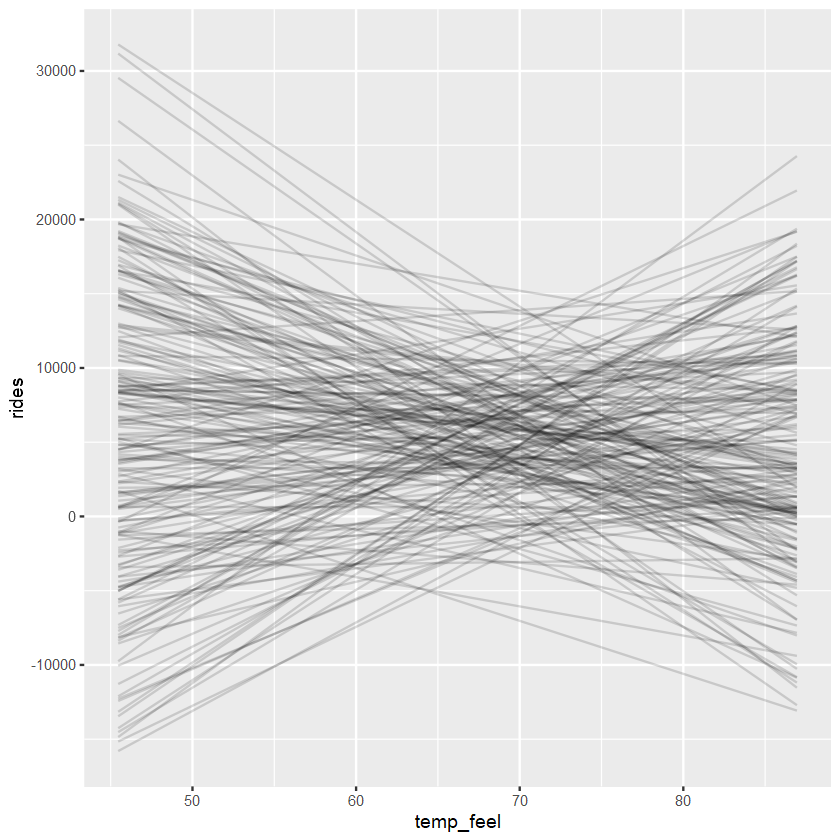

In [108]:
bikes %>%
  add_fitted_draws(bike_default_priors, n = 200) %>%
  ggplot(aes(x = temp_feel, y = rides)) +
    geom_line(aes(y = .value, group = .draw), alpha = 0.15)

Warning message:
"
In add_predicted_draws(): The `n` argument is a deprecated alias for `ndraws`.
Use the `ndraws` argument instead.
See help("tidybayes-deprecated").
"


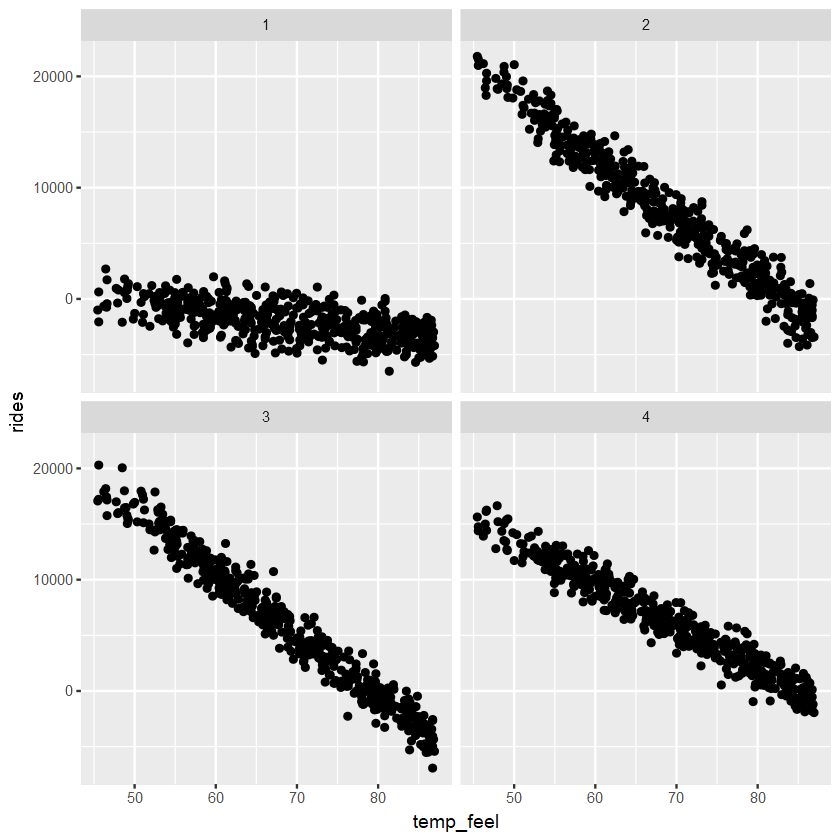

In [109]:
set.seed(3)
bikes %>%
  add_predicted_draws(bike_default_priors, n = 4) %>%
  ggplot(aes(x = temp_feel, y = rides)) +
    geom_point(aes(y = .prediction, group = .draw)) + 
    facet_wrap(~ .draw)